# July 31st, 2021

**Motivation**: A combo of useful stuf, not cleaned up, but still useful to go back for a piece of code <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
svinet_ws = pjoin(os.environ['HOME'], 'Documents/workspaces/svinet')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import load_allen, make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.svinet import *
from utils.plotting import *
from utils.render import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

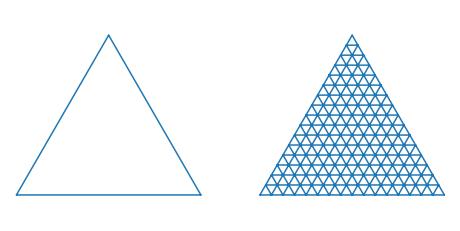

In [2]:
import matplotlib.tri as tri

corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
AREA = 0.5 * 1 * 0.75**0.5
triangle = tri.Triangulation(corners[:, 0], corners[:, 1])

refiner = tri.UniformTriRefiner(triangle)
trimesh = refiner.refine_triangulation(subdiv=4)

plt.figure(figsize=(8, 4))
for (i, mesh) in enumerate((triangle, trimesh)):
    plt.subplot(1, 2, i+ 1)
    plt.triplot(mesh)
    plt.axis('off')
    plt.axis('equal')

In [27]:
# For each corner of the triangle, the pair of other corners
pairs = [corners[np.roll(range(3), -i)[1:]] for i in range(3)]
# The area of the triangle formed by point xy and another pair or points
tri_area = lambda xy, pair: 0.5 * np.linalg.norm(np.cross(*(pair - xy)))

def xy2bc(xy, tol=1.e-4):
    '''Converts 2D Cartesian coordinates to barycentric.'''
    coords = np.array([tri_area(xy, p) for p in pairs]) / AREA
    return np.clip(coords, tol, 1.0 - tol)

class Dirichlet(object):
    def __init__(self, alpha):
        from math import gamma
        from operator import mul
        self._alpha = np.array(alpha)
        self._coef = gamma(np.sum(self._alpha)) / \
                           np.multiply.reduce([gamma(a) for a in self._alpha])
    def pdf(self, x):
        '''Returns pdf value for `x`.'''
        from operator import mul
        return self._coef * np.multiply.reduce([xx ** (aa - 1)
                                               for (xx, aa)in zip(x, self._alpha)])
    
def draw_pdf_contours(dist, nlevels=200, subdiv=8, **kwargs):
    import math

    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    pvals = [dist.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]

    plt.tricontourf(trimesh, pvals, nlevels, cmap='jet', **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')

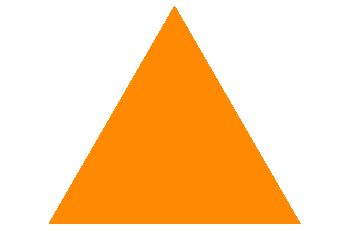

In [28]:
draw_pdf_contours(Dirichlet([1, 1, 1]))

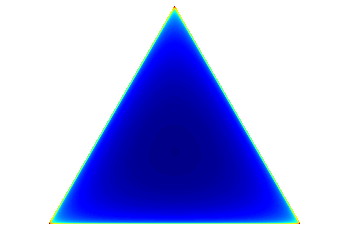

In [29]:
draw_pdf_contours(Dirichlet([0.9999, 0.9999, 0.9999]))

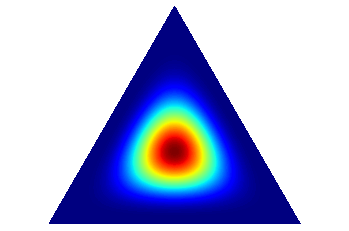

In [30]:
draw_pdf_contours(Dirichlet([5, 5, 5]))

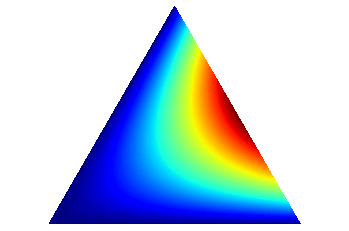

In [31]:
draw_pdf_contours(Dirichlet([1, 2, 2]))

## Mice

In [2]:
mice = Mice(Config(128))
mice.combine_dfs('both', full=True)

key = 'sub-SLC07' # 'sub-SLC02_ses-2' # 'sub-SLC'
mode = 'bold'
metric = 'spearman'
match_metric = 'cosine'

In [35]:
tasks = {}
for key in mice.bold_combined:
    if 'run' not in key:
        continue
    tasks[key] = mice.bold[key].task

In [183]:
key = 'sub-SLC07_ses-3_run-7'
tasks[key]

'rest'

In [184]:
hier = Hierarchical(
    mice=mice,
    key=key,
    mode='bold',
    metric='correlation',
).fit(range(4, 7)).make_clusters()

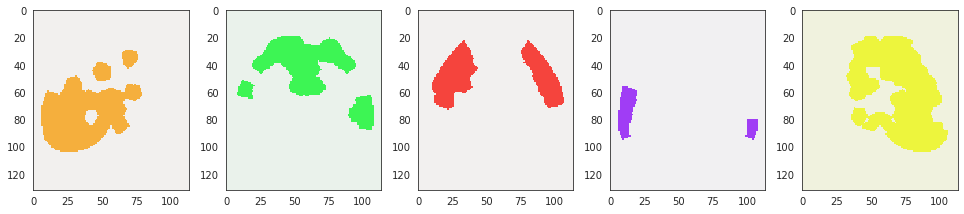

In [185]:
num_k = 5

masks = hier.results[num_k]['cluster_masks'].copy()
masks = {k: m * mice.allen['isocortex_mask'] for k, m in masks.items()}

fig, axes = create_figure(1, num_k, (13.5, 3.5))
for idx in range(1, num_k + 1):
    x = project_vol_2d(masks[idx], mice.allen['dims_flat'], mode='max_proj')
    axes[idx-1].imshow(x, cmap=get_cluster_cmap(idx))
    

In [50]:
_ = cluster2html(
    cluster=hier.clusters[num_k],
    n_cortex_regions=128,
    save_dir=extras_dir,
    save_name='HIER_test',
)

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/HIER_test_render-128_n-5.html

In [ ]:
# stim = pd.read_csv('~/Documents/Stim.csv', index_col=0)
# stim

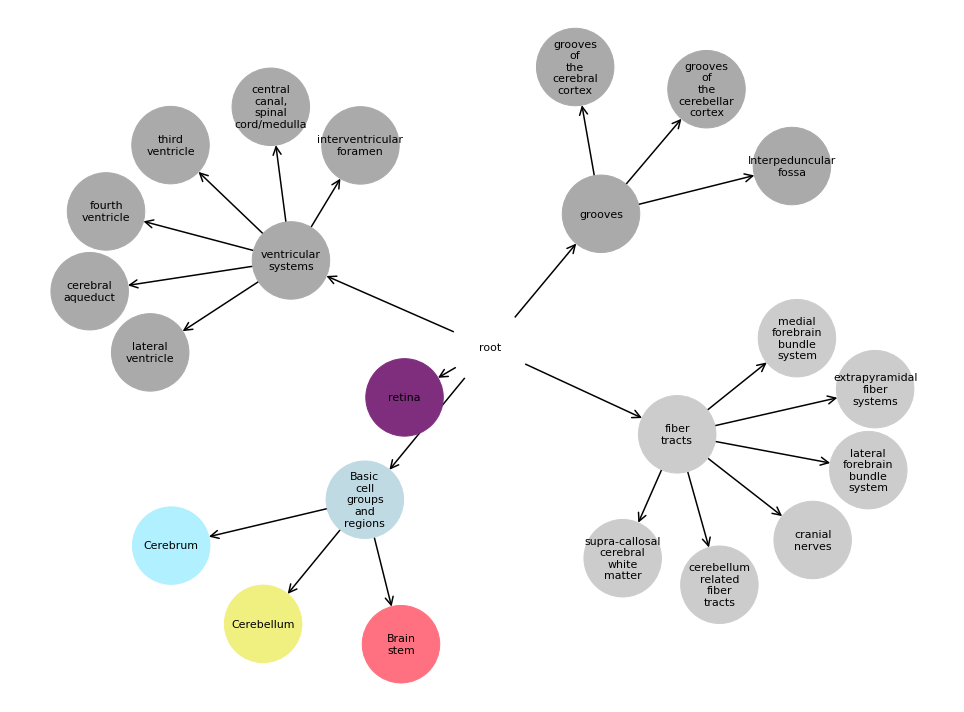

In [3]:
n_levels = 3
root = 'root'
tree = make_tree_graph(root, n_levels=n_levels, use_acroym=False)

_ = plot_nx_tree(tree, 'neato', node_size=6000)

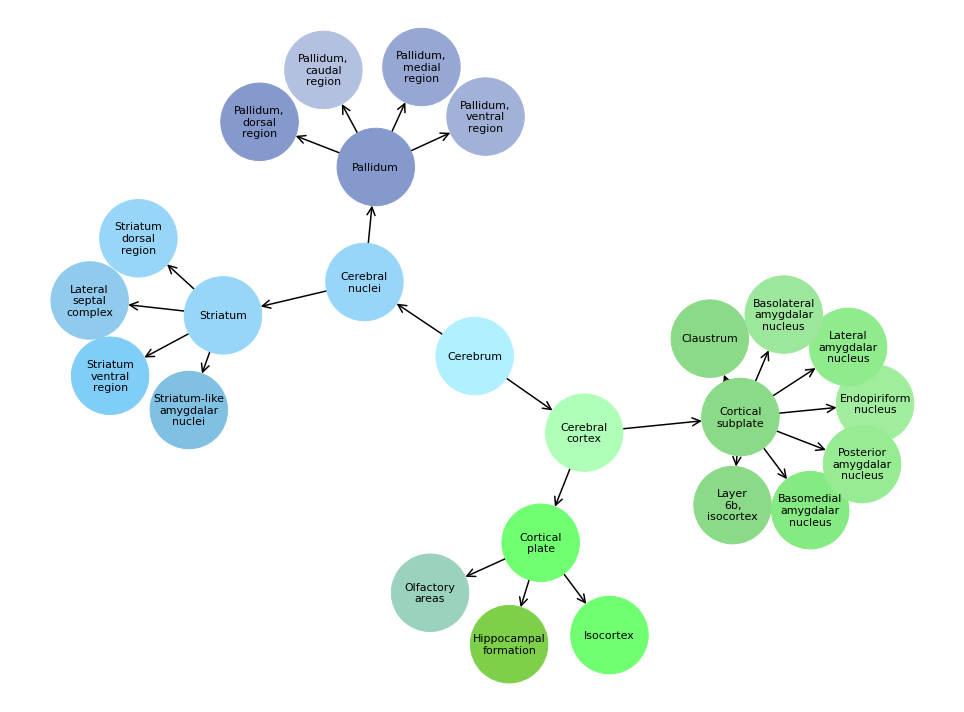

In [5]:
n_levels = 4
root = 'Cerebrum'
tree = make_tree_graph(root, n_levels=n_levels, use_acroym=False)

_ = plot_nx_tree(tree, 'neato', node_size=6000)

In [6]:
progs = [
    'neato',
    'dot',
    'twopi',
    'circo',
    'fdp',
    'nop',
    'wc',
    'acyclic',
    'gvpr',
    'gvcolor',
    'ccomps',
    'sccmap',
    'tred',
    'sfdp',
    'unflatten',
]

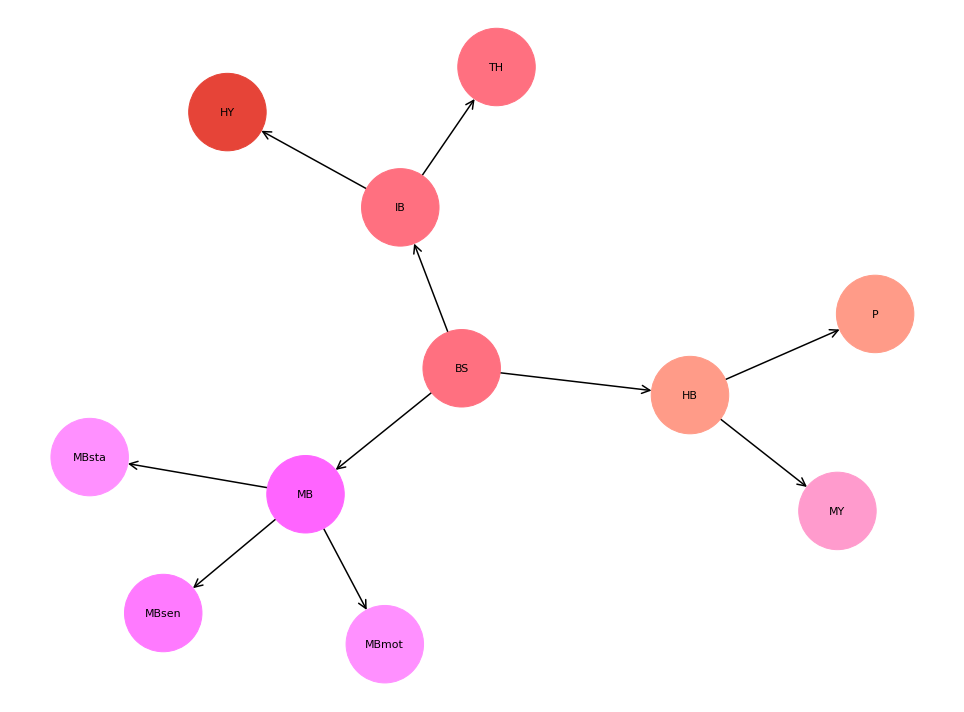

In [8]:
n_levels = 3
root = 'BS' # 'Brain stem'
tree = make_tree_graph(root, n_levels=n_levels, use_acroym=True)

_ = plot_nx_tree(tree, 'neato', node_size=6000)

In [3]:
from register.atlas import get_summary_table

In [4]:
table = get_summary_table()
print(table)

allen mouse atlas (res. 100um)
From: http://www.brain-map.org (Wang et al 2020, https://doi.org/10.1016/j.cell.2020.04.007 )


+-----+------+--------------------------------------+-----------+----------+---------------+
| lvl |  id  | name                                 |  acronym  | # voxels | relative size |
+-----+------+--------------------------------------+-----------+----------+---------------+
| --- | ---  | ---                                  |    ---    |   ---    |      ---      |
|  5  | 315  | Isocortex                            | Isocortex |  123245  |     100 %     |
| --- | ---  | ---                                  |    ---    |   ---    |      ---      |
|  6  |  31  | Anterior cingulate area              |    ACA    |   5501   |      4 %      |
|  6  |  95  | Agranular insular area               |     AI    |   7892   |      6 %      |
|  6  | 247  | Auditory areas                       |    AUD    |   5770   |      5 %      |
|  6  | 895  | Ectorhinal area                      |    ECT    |   1728   |      1 %      |
|  6  | 184  | Frontal pole, cerebral cortex        |    FRP    |   966    |      1 %      |
|  6  | 1057 | Gustatory areas                      |     GU    |   1760   |      1 %      |
|  6  |  44  | Infralimbic area                     |    ILA    |   849    |      1 %      |
|  6  | 500  | Somatomotor areas                    |     MO    |  24472   |      20 %     |
|  6  | 714  | Orbital area                         |    ORB    |   5886   |      5 %      |
|  6  | 922  | Perirhinal area                      |    PERI   |   797    |      1 %      |
|  6  | 972  | Prelimbic area                       |     PL    |   2433   |      2 %      |
|  6  |  22  | Posterior parietal association areas |    PTLp   |   2454   |      2 %      |
|  6  | 254  | Retrosplenial area                   |    RSP    |  10455   |      8 %      |
|  6  | 453  | Somatosensory areas                  |     SS    |  33317   |      27 %     |
|  6  | 541  | Temporal association areas           |    TEa    |   3106   |      3 %      |
|  6  | 669  | Visual areas                         |    VIS    |  13489   |      11 %     |
|  6  | 677  | Visceral area                        |    VISC   |   2370   |      2 %      |
| --- | ---  | ---                                  |    ---    |   ---    |      ---      |
|  7  | 985  | Primary motor area                   |    MOp    |  11376   |      9 %      |
|  7  | 993  | Secondary motor area                 |    MOs    |  13096   |      11 %     |
| --- | ---  | ---                                  |    ---    |   ---    |      ---      |
|  7  | 322  | Primary somatosensory area           |    SSp    |  24324   |      20 %     |
|  7  | 378  | Supplemental somatosensory area      |    SSs    |   8993   |      7 %      |
| --- | ---  | ---                                  |    ---    |   ---    |      ---      |
|  8  | 329  | SSp, barrel field                    |  SSp-bfd  |   6281   |      5 %      |
|  8  | 337  | SSp, lower limb                      |   SSp-ll  |   2361   |      2 %      |
|  8  | 345  | SSp, mouth                           |   SSp-m   |   6224   |      5 %      |
|  8  | 353  | SSp, nose                            |   SSp-n   |   3032   |      2 %      |
|  8  | 361  | SSp, trunk                           |   SSp-tr  |   1399   |      1 %      |
|  8  | 369  | SSp, upper limb                      |   SSp-ul  |   3764   |      3 %      |
|  8  |      | SSp, unassigned                      |   SSp-un  |   1263   |      1 %      |
| --- | ---  | ---                                  |    ---    |   ---    |      ---      |
+-----+------+--------------------------------------+-----------+----------+---------------+

In [5]:
allen = load_allen()

grey = allen['structure_tree'].get_structures_by_acronym(['grey'])[0]
grey_child_ids = allen['structure_tree'].child_ids([grey['id']])[0]
grey_childs = allen['structure_tree'].get_structures_by_id(grey_child_ids)

In [6]:
grey_childs

[
    {
        'acronym': 'CH',
        'graph_id': 1,
        'graph_order': 2,
        'id': 567,
        'name': 'Cerebrum',
        'structure_id_path': [997, 8, 567],
        'structure_set_ids': [
            112905828,
            691663206,
            12,
            184527634,
            112905813,
            114512891,
            114512892
        ],
        'rgb_triplet': [176, 240, 255]
    },
    {
        'acronym': 'BS',
        'graph_id': 1,
        'graph_order': 639,
        'id': 343,
        'name': 'Brain stem',
        'structure_id_path': [997, 8, 343],
        'structure_set_ids': [
            112905828,
            691663206,
            12,
            184527634,
            112905813,
            114512891,
            114512892
        ],
        'rgb_triplet': [255, 112, 128]
    },
    {
        'acronym': 'CB',
        'graph_id': 1,
        'graph_order': 1014,
        'id': 512,
        'name': 'Cerebellum',
        'structure_id_path': [997, 8, 512],
        'structure_set_ids': [
            2,
            112905828,
            691663206,
            12,
            184527634,
            112905813,
            687527670,
            114512891,
            114512892
        ],
        'rgb_triplet': [240, 240, 128]
    }
]

In [7]:
table = get_summary_table(structs=['CH', 'BS', 'CB'])
print(table)

allen mouse atlas (res. 100um)
From: http://www.brain-map.org (Wang et al 2020, https://doi.org/10.1016/j.cell.2020.04.007 )


+-----+------+-------------------+---------+----------+---------------+
| lvl |  id  | name              | acronym | # voxels | relative size |
+-----+------+-------------------+---------+----------+---------------+
| --- | ---  | ---               |   ---   |   ---    |      ---      |
|  2  | 567  | Cerebrum          |    CH   |  275611  |     224 %     |
| --- | ---  | ---               |   ---   |   ---    |      ---      |
|  3  | 623  | Cerebral nuclei   |   CNU   |  54359   |      44 %     |
|  3  | 688  | Cerebral cortex   |   CTX   |  221252  |     180 %     |
| --- | ---  | ---               |   ---   |   ---    |      ---      |
|  2  | 343  | Brain stem        |    BS   |  119632  |      97 %     |
| --- | ---  | ---               |   ---   |   ---    |      ---      |
|  3  | 1065 | Hindbrain         |    HB   |  47624   |      39 %     |
|  3  | 1129 | Interbrain        |    IB   |  35335   |      29 %     |
|  3  | 313  | Midbrain          |    MB   |  36673   |      30 %     |
| --- | ---  | ---               |   ---   |   ---    |      ---      |
|  2  | 512  | Cerebellum        |    CB   |  53719   |      44 %     |
| --- | ---  | ---               |   ---   |   ---    |      ---      |
|  3  | 519  | Cerebellar nuclei |   CBN   |   1770   |      1 %      |
|  3  | 528  | Cerebellar cortex |   CBX   |  51138   |      41 %     |
| --- | ---  | ---               |   ---   |   ---    |      ---      |
+-----+------+-------------------+---------+----------+---------------+

In [82]:
table = get_summary_table(structs=['CB'])
print(table)

allen mouse atlas (res. 100um)
From: http://www.brain-map.org (Wang et al 2020, https://doi.org/10.1016/j.cell.2020.04.007 )


+-----+-----+-------------------+---------+----------+---------------+
| lvl |  id | name              | acronym | # voxels | relative size |
+-----+-----+-------------------+---------+----------+---------------+
| --- | --- | ---               |   ---   |   ---    |      ---      |
|  2  | 512 | Cerebellum        |    CB   |  53719   |      44 %     |
| --- | --- | ---               |   ---   |   ---    |      ---      |
|  3  | 519 | Cerebellar nuclei |   CBN   |   1770   |      1 %      |
|  3  | 528 | Cerebellar cortex |   CBX   |  51138   |      41 %     |
| --- | --- | ---               |   ---   |   ---    |      ---      |
+-----+-----+-------------------+---------+----------+---------------+

In [86]:
table = get_summary_table(structs=['CBX'])
print(table)

allen mouse atlas (res. 100um)
From: http://www.brain-map.org (Wang et al 2020, https://doi.org/10.1016/j.cell.2020.04.007 )


+-----+------+---------------------+---------+----------+---------------+
| lvl |  id  | name                | acronym | # voxels | relative size |
+-----+------+---------------------+---------+----------+---------------+
| --- | ---  | ---                 |   ---   |   ---    |      ---      |
|  3  | 528  | Cerebellar cortex   |   CBX   |  51138   |      41 %     |
| --- | ---  | ---                 |   ---   |   ---    |      ---      |
|  4  | 1073 | Hemispheric regions |   HEM   |  30895   |      25 %     |
|  4  | 645  | Vermal regions      |   VERM  |  20243   |      16 %     |
| --- | ---  | ---                 |   ---   |   ---    |      ---      |
+-----+------+---------------------+---------+----------+---------------+

In [92]:
allen['structure_tree'].get_structures_by_acronym(['Isocortex'])

[
    {
        'acronym': 'Isocortex',
        'graph_id': 1,
        'graph_order': 5,
        'id': 315,
        'name': 'Isocortex',
        'structure_id_path': [997, 8, 567, 688, 695, 315],
        'structure_set_ids': [
            2,
            112905828,
            691663206,
            12,
            184527634,
            112905813,
            687527670,
            114512891,
            114512892
        ],
        'rgb_triplet': [112, 255, 113]
    }
]

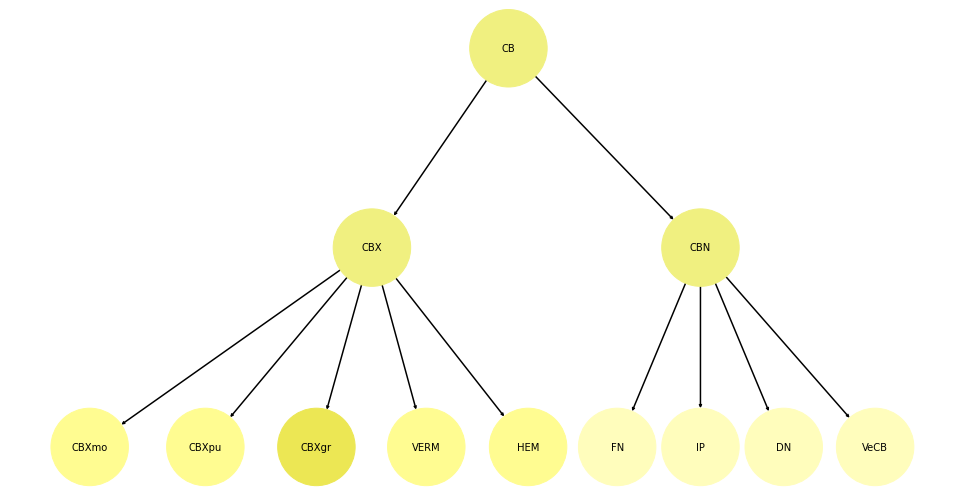

In [321]:
n_levels = 3
root = 'CB' # 'Brain stem'
tree = make_tree_graph(root, n_levels=n_levels, use_acroym=True)

_ = plot_nx_tree(tree, 'dot', node_size=6000, figsize=(13.5, 7))

In [5]:
allen = load_allen()

In [6]:
from register.parcellation import get_major_masks

In [7]:
{
    k: np.round(m.sum() / allen['isocortex_mask'].sum() * 100, 1)
    for k, m in get_major_masks().items()
}

allen mouse atlas (res. 100um)
From: http://www.brain-map.org (Wang et al 2020, https://doi.org/10.1016/j.cell.2020.04.007 )


{
    'PAL': 7.5,
    'STR': 36.6,
    'CTXsp': 7.2,
    'OLF': 37.7,
    'HIP': 19.3,
    'RHP': 15.0,
    'IB': 28.7,
    'MB': 29.8,
    'HB': 38.6,
    'CB': 43.6,
    'VIS': 10.9,
    'TEa': 2.5,
    'PERI': 0.6,
    'ECT': 1.4,
    'RSP': 8.5,
    'AUD': 4.7,
    'PTLp': 2.0,
    'VISC': 1.9,
    'SS': 27.0,
    'SSp': 19.7,
    'SSp-bfd': 5.1,
    'SSp-ll': 1.9,
    'SSp-m': 5.1,
    'SSp-n': 2.5,
    'SSp-tr': 1.1,
    'SSp-ul': 3.1,
    'SSp-un': 1.0,
    'SSs': 7.3,
    'GU': 1.4,
    'ACA': 4.5,
    'AI': 6.4,
    'MO': 19.9,
    'MOp': 9.2,
    'MOs': 10.6,
    'ILA': 0.7,
    'PL': 2.0,
    'ORB': 4.8,
    'FRP': 0.8
}

In [155]:
table = get_summary_table(structs=['ENT'])
print(table)

allen mouse atlas (res. 100um)
From: http://www.brain-map.org (Wang et al 2020, https://doi.org/10.1016/j.cell.2020.04.007 )


+-----+-----+-------------------------------------------+---------+----------+---------------
+
| lvl |  id | name                                      | acronym | # voxels | relative size 
|
+-----+-----+-------------------------------------------+---------+----------+---------------
+
| --- | --- | ---                                       |   ---   |   ---    |      ---      
|
|  7  | 909 | Entorhinal area                           |   ENT   |  11476   |      9 %      
|
| --- | --- | ---                                       |   ---   |   ---    |      ---      
|
|  8  | 918 | Entorhinal area, lateral part             |   ENTl  |   6391   |      5 %      
|
|  8  | 926 | Entorhinal area, medial part, dorsal zone |   ENTm  |   5085   |      4 %      
|
| --- | --- | ---                                       |   ---   |   ---    |      ---      
|
+-----+-----+-------------------------------------------+---------+----------+---------------
+

In [288]:
include_regions = [
    'Striatum',
    'Pallidum',
    'Olfactory areas',
    'Cortical subplate',
    'Hippocampal formation',
    'Isocortex',
]

In [289]:
allen['structure_tree'].get_structures_by_name(include_regions)

[
    {
        'acronym': 'STR',
        'graph_id': 1,
        'graph_order': 571,
        'id': 477,
        'name': 'Striatum',
        'structure_id_path': [997, 8, 567, 623, 477],
        'structure_set_ids': [
            2,
            112905828,
            691663206,
            12,
            184527634,
            112905813,
            687527670,
            114512891,
            114512892
        ],
        'rgb_triplet': [152, 214, 249]
    },
    {
        'acronym': 'PAL',
        'graph_id': 1,
        'graph_order': 608,
        'id': 803,
        'name': 'Pallidum',
        'structure_id_path': [997, 8, 567, 623, 803],
        'structure_set_ids': [
            2,
            112905828,
            691663206,
            12,
            184527634,
            112905813,
            687527670,
            114512891,
            114512892
        ],
        'rgb_triplet': [133, 153, 204]
    },
    {
        'acronym': 'OLF',
        'graph_id': 1,
        'graph_order': 379,
        'id': 698,
        'name': 'Olfactory areas',
        'structure_id_path': [997, 8, 567, 688, 695, 698],
        'structure_set_ids': [
            2,
            3,
            112905828,
            691663206,
            12,
            184527634,
            112905813,
            687527670,
            114512891,
            114512892
        ],
        'rgb_triplet': [154, 210, 189]
    },
    {
        'acronym': 'CTXsp',
        'graph_id': 1,
        'graph_order': 555,
        'id': 703,
        'name': 'Cortical subplate',
        'structure_id_path': [997, 8, 567, 688, 703],
        'structure_set_ids': [
            2,
            3,
            112905828,
            691663206,
            12,
            184527634,
            687527670,
            114512891
        ],
        'rgb_triplet': [138, 218, 135]
    },
    {
        'acronym': 'HPF',
        'graph_id': 1,
        'graph_order': 454,
        'id': 1089,
        'name': 'Hippocampal formation',
        'structure_id_path': [997, 8, 567, 688, 695, 1089],
        'structure_set_ids': [
            2,
            112905828,
            691663206,
            12,
            184527634,
            112905813,
            687527670,
            114512891,
            114512892
        ],
        'rgb_triplet': [126, 208, 75]
    },
    {
        'acronym': 'Isocortex',
        'graph_id': 1,
        'graph_order': 5,
        'id': 315,
        'name': 'Isocortex',
        'structure_id_path': [997, 8, 567, 688, 695, 315],
        'structure_set_ids': [
            2,
            112905828,
            691663206,
            12,
            184527634,
            112905813,
            687527670,
            114512891,
            114512892
        ],
        'rgb_triplet': [112, 255, 113]
    }
]

In [270]:
def regions_to_include(
    allen: dict = None,
    childs_of: List[str] = None,
    extras: List[str] = None,
    remove: List[str] = None, ):
    
    allen = allen if allen else load_allen()
    childs_of = childs_of if childs_of else [
        'PAL',
        'STR',
        'OLF',
        'HIP',
        'ENT',
        'RHP',
        'MY',
        'P',
        'IB',
        'TH',
        'MB',
        'CB',
        'CBX',
        'HEM',
    ]
    extras = extras if extras else [
        'CTXsp',
        'Isocortex',
    ]
    remove = remove if remove else [
        'FC',
        'IG',
        # 'HB',
        # 'DP',
        # 'NLOT',
        'ENTmv',
        'CBXmo',
        'CBXpu',
        'CBXgr',
        'MY-sat',
        # 'HATA',
        # 'APr',
    ]
    structs = allen['structure_tree'].get_structures_by_acronym(childs_of)
    children = allen['structure_tree'].children([e['id'] for e in structs])
    children_acros = [e['acronym'] for item in children for e in item]
    regions = [e for e in children_acros if e not in childs_of + remove]
    regions += extras
    return regions

In [271]:
regions = regions_to_include()

In [272]:
regions

[
    'PALd',
    'PALv',
    'PALm',
    'PALc',
    'STRd',
    'STRv',
    'LSX',
    'sAMY',
    'MOB',
    'AOB',
    'AON',
    'TT',
    'DP',
    'PIR',
    'NLOT',
    'COA',
    'PAA',
    'TR',
    'CA',
    'DG',
    'ENTl',
    'ENTm',
    'PAR',
    'POST',
    'PRE',
    'SUB',
    'ProS',
    'HATA',
    'APr',
    'MY-sen',
    'MY-mot',
    'P-sen',
    'P-mot',
    'P-sat',
    'HY',
    'DORsm',
    'DORpm',
    'MBsen',
    'MBmot',
    'MBsta',
    'CBN',
    'VERM',
    'SIM',
    'AN',
    'PRM',
    'COPY',
    'PFL',
    'FL',
    'CTXsp',
    'Isocortex'
]

In [273]:
len(regions), len(set(regions))

(50, 50)

In [274]:
allen = load_allen()
structs = allen['structure_tree'].get_structures_by_acronym(regions)

In [275]:
for s in structs:
    mask = allen['mcc'].get_structure_mask(s['id'])[0]
    ratio = mask.sum() / allen['isocortex_mask'].sum() * 100
    print(f"acro: {s['acronym']}\t# vox: {mask.sum()}\tratio: {ratio:.0f} %\tname: {s['name']}")

acro: PALd      # vox: 1987     ratio: 2 %      name: Pallidum, dorsal region

acro: PALv      # vox: 3367     ratio: 3 %      name: Pallidum, ventral region

acro: PALm      # vox: 1484     ratio: 1 %      name: Pallidum, medial region

acro: PALc      # vox: 1349     ratio: 1 %      name: Pallidum, caudal region

acro: STRd      # vox: 26040    ratio: 21 %     name: Striatum dorsal region

acro: STRv      # vox: 8699     ratio: 7 %      name: Striatum ventral region

acro: LSX       # vox: 3584     ratio: 3 %      name: Lateral septal complex

acro: sAMY      # vox: 4057     ratio: 3 %      name: Striatum-like amygdalar nuclei

acro: MOB       # vox: 16406    ratio: 13 %     name: Main olfactory bulb

acro: AOB       # vox: 650      ratio: 1 %      name: Accessory olfactory bulb

acro: AON       # vox: 4880     ratio: 4 %      name: Anterior olfactory nucleus

acro: TT        # vox: 1431     ratio: 1 %      name: Taenia tecta

acro: DP        # vox: 482      ratio: 0 %      name: Dorsal peduncular area

acro: PIR       # vox: 11591    ratio: 9 %      name: Piriform area

acro: NLOT      # vox: 311      ratio: 0 %      name: Nucleus of the lateral olfactory tract

acro: COA       # vox: 3258     ratio: 3 %      name: Cortical amygdalar area

acro: PAA       # vox: 1235     ratio: 1 %      name: Piriform-amygdalar area

acro: TR        # vox: 1323     ratio: 1 %      name: Postpiriform transition area

acro: CA        # vox: 17018    ratio: 14 %     name: Ammon's horn

acro: DG        # vox: 6571     ratio: 5 %      name: Dentate gyrus

acro: ENTl      # vox: 6391     ratio: 5 %      name: Entorhinal area, lateral part

acro: ENTm      # vox: 5085     ratio: 4 %      name: Entorhinal area, medial part, dorsal 
zone

acro: PAR       # vox: 930      ratio: 1 %      name: Parasubiculum

acro: POST      # vox: 1074     ratio: 1 %      name: Postsubiculum

acro: PRE       # vox: 906      ratio: 1 %      name: Presubiculum

acro: SUB       # vox: 2146     ratio: 2 %      name: Subiculum

acro: ProS      # vox: 1185     ratio: 1 %      name: Prosubiculum

acro: HATA      # vox: 420      ratio: 0 %      name: Hippocampo-amygdalar transition area

acro: APr       # vox: 361      ratio: 0 %      name: Area prostriata

acro: MY-sen    # vox: 7891     ratio: 6 %      name: Medulla, sensory related

acro: MY-mot    # vox: 17471    ratio: 14 %     name: Medulla, motor related

acro: P-sen     # vox: 3893     ratio: 3 %      name: Pons, sensory related

acro: P-mot     # vox: 5772     ratio: 5 %      name: Pons, motor related

acro: P-sat     # vox: 3427     ratio: 3 %      name: Pons, behavioral state related

acro: HY        # vox: 15066    ratio: 12 %     name: Hypothalamus

acro: DORsm     # vox: 6697     ratio: 5 %      name: Thalamus, sensory-motor cortex related

acro: DORpm     # vox: 12698    ratio: 10 %     name: Thalamus, polymodal association cortex 
related

acro: MBsen     # vox: 6838     ratio: 6 %      name: Midbrain, sensory related

acro: MBmot     # vox: 21343    ratio: 17 %     name: Midbrain, motor related

acro: MBsta     # vox: 1813     ratio: 1 %      name: Midbrain, behavioral state related

acro: CBN       # vox: 1770     ratio: 1 %      name: Cerebellar nuclei

acro: VERM      # vox: 20243    ratio: 16 %     name: Vermal regions

acro: SIM       # vox: 5709     ratio: 5 %      name: Simple lobule

acro: AN        # vox: 10778    ratio: 9 %      name: Ansiform lobule

acro: PRM       # vox: 4866     ratio: 4 %      name: Paramedian lobule

acro: COPY      # vox: 2490     ratio: 2 %      name: Copula pyramidis

acro: PFL       # vox: 5742     ratio: 5 %      name: Paraflocculus

acro: FL        # vox: 1310     ratio: 1 %      name: Flocculus

acro: CTXsp     # vox: 8850     ratio: 7 %      name: Cortical subplate

acro: Isocortex # vox: 123245   ratio: 100 %    name: Isocortex

In [276]:
s['acronym']

'Isocortex'

In [279]:

structs = allen['structure_tree'].get_structures_by_acronym(['NLOT'])
struct_ids = [e['id'] for e in structs]
struct_ids

[619]

In [226]:
allen['structure_tree'].children(struct_ids)

[
    [
        {
            'acronym': 'DP1',
            'graph_id': 1,
            'graph_order': 411,
            'id': 496,
            'name': 'Dorsal peduncular area, layer 1',
            'structure_id_path': [997, 8, 567, 688, 695, 698, 814, 496],
            'structure_set_ids': [12],
            'rgb_triplet': [164, 218, 164]
        },
        {
            'acronym': 'DP2',
            'graph_id': 1,
            'graph_order': 412,
            'id': 535,
            'name': 'Dorsal peduncular area, layer 2',
            'structure_id_path': [997, 8, 567, 688, 695, 698, 814, 535],
            'structure_set_ids': [],
            'rgb_triplet': [164, 218, 164]
        },
        {
            'acronym': 'DP2/3',
            'graph_id': 1,
            'graph_order': 413,
            'id': 360,
            'name': 'Dorsal peduncular area, layer 2/3',
            'structure_id_path': [997, 8, 567, 688, 695, 698, 814, 360],
            'structure_set_ids': [12],
            'rgb_triplet': [164, 218, 164]
        },
        {
            'acronym': 'DP5',
            'graph_id': 1,
            'graph_order': 414,
            'id': 646,
            'name': 'Dorsal peduncular area, layer 5',
            'structure_id_path': [997, 8, 567, 688, 695, 698, 814, 646],
            'structure_set_ids': [12],
            'rgb_triplet': [164, 218, 164]
        },
        {
            'acronym': 'DP6a',
            'graph_id': 1,
            'graph_order': 415,
            'id': 267,
            'name': 'Dorsal peduncular area, layer 6a',
            'structure_id_path': [997, 8, 567, 688, 695, 698, 814, 267],
            'structure_set_ids': [12],
            'rgb_triplet': [164, 218, 164]
        }
    ]
]

In [178]:
ref_space = allen['mcc'].get_reference_space()

672

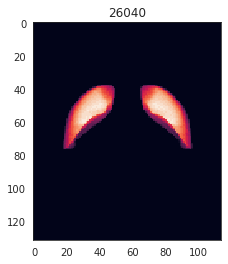

485

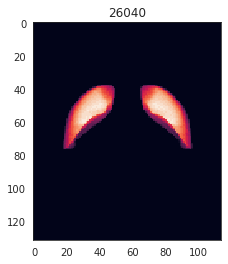

In [179]:
for identifier, m in ref_space.many_structure_masks([672, 485]):
    print(identifier)
    plt.imshow(m.mean(1))
    plt.title(m.sum())
    plt.show()

In [78]:
(m > 0).sum()

1373

In [284]:
s = allen['structure_tree'].get_structures_by_acronym(['APr'])[0]
m = allen['mcc'].get_structure_mask(s['id'])[0]
m.sum()

361

In [285]:
space = 'CCF'
key_space = f"space-{space}"
mice = Mice(Config(128), load_preproc=True, load_df=False)

_masks_all = {}
for key, anat in tqdm(mice.T1w.items()):
    moving = anat.get_data()
    if moving is None:
        continue
    moving = reorient_arr(moving)
    moving = reset_ants_img(moving)

    tx = '_'.join([key, key_space, 'ants-SyN'])
    tx = list(filter(lambda f: tx in f, os.listdir(mice.cfg.tx_dir)))
    tx = [pjoin(mice.cfg.tx_dir, f) for f in sorted(tx)]

    m_inv = ants.apply_transforms(
        fixed=moving,
        moving=reset_ants_img(m),
        transformlist=tx,
        interpolator='genericLabel',
    ).numpy().astype(bool)
    
    print(key, m_inv.sum(), m.sum() / m_inv.sum())

  0%|          | 0/30 [00:00<?, ?it/s]

sub-SLC01_ses-1 35 10.314285714285715

sub-SLC01_ses-2 33 10.93939393939394

sub-SLC01_ses-3 33 10.93939393939394

sub-SLC02_ses-1 34 10.617647058823529

sub-SLC02_ses-2 31 11.64516129032258

sub-SLC02_ses-3 34 10.617647058823529

sub-SLC03_ses-1 32 11.28125

sub-SLC03_ses-2 35 10.314285714285715

sub-SLC03_ses-3 36 10.027777777777779

sub-SLC04_ses-1 34 10.617647058823529

sub-SLC04_ses-2 42 8.595238095238095

sub-SLC04_ses-3 29 12.448275862068966

sub-SLC05_ses-1 41 8.804878048780488

sub-SLC05_ses-2 35 10.314285714285715

sub-SLC05_ses-3 34 10.617647058823529

sub-SLC06_ses-1 33 10.93939393939394

sub-SLC06_ses-2 36 10.027777777777779

sub-SLC06_ses-3 34 10.617647058823529

sub-SLC07_ses-1 33 10.93939393939394

sub-SLC07_ses-2 37 9.756756756756756

sub-SLC07_ses-3 32 11.28125

sub-SLC08_ses-1 31 11.64516129032258

sub-SLC08_ses-2 33 10.93939393939394

sub-SLC08_ses-3 31 11.64516129032258

sub-SLC09_ses-1 32 11.28125

sub-SLC09_ses-2 39 9.256410256410257

sub-SLC09_ses-3 35 10.314285714285715

sub-SLC10_ses-1 37 9.756756756756756

sub-SLC10_ses-2 32 11.28125

sub-SLC10_ses-3 29 12.448275862068966

In [286]:
m_inv.sum()

29

In [287]:
m.sum() / m_inv.sum()

12.448275862068966

In [10]:
from bg_atlasapi import show_atlases
show_atlases()

                                                                                  
                                                                                  
                                Brainglobe Atlases                                
╭──────────────────────────────────┬────────────┬───────────────┬────────────────╮
│ Name                             │ Downloaded │ Local version │ Latest version │
├──────────────────────────────────┼────────────┼───────────────┼────────────────┤
│ mpin_zfish_1um                   │     ✔      │      1.0      │      1.0       │
│ kim_mouse_100um                  │     ✔      │      1.0      │      1.0       │
│ allen_mouse_100um                │     ✔      │      1.2      │      1.2       │
│ example_mouse_100um              │    ---     │      ---      │      1.2       │
│ allen_mouse_10um                 │    ---     │      ---      │      1.2       │
│ allen_mouse_25um                 │    ---     │      ---      │      1.2       │
│ allen_mouse_50um                 │    ---     │      ---      │      1.2       │
│ allen_human_500um                │    ---     │      ---      │      0.1       │
│ kim_mouse_10um                   │    ---     │      ---      │      1.0       │
│ kim_mouse_25um                   │    ---     │      ---      │      1.0       │
│ kim_mouse_50um                   │    ---     │      ---      │      1.0       │
│ osten_mouse_10um                 │    ---     │      ---      │      1.1       │
│ osten_mouse_25um                 │    ---     │      ---      │      1.1       │
│ osten_mouse_50um                 │    ---     │      ---      │      1.1       │
│ osten_mouse_100um                │    ---     │      ---      │      1.1       │
╰──────────────────────────────────┴────────────┴───────────────┴────────────────╯

In [11]:
from bg_atlasapi import BrainGlobeAtlas

In [19]:
a = BrainGlobeAtlas('allen_mouse_100um')
b = BrainGlobeAtlas('kim_mouse_100um')


allen mouse atlas (res. 100um)
From: http://www.brain-map.org (Wang et al 2020, https://doi.org/10.1016/j.cell.2020.04.007 )
kim mouse atlas (res. 100um)
From: https://kimlab.io/brain-map/atlas/ (Chon et al. 2019, https://doi.org/10.1038/s41467-019-13057-w )


In [20]:
a.annotation.shape

(132, 80, 114)

In [33]:
map_a = {j: i for i, j in enumerate(np.unique(a.annotation))}
map_b = {j: i for i, j in enumerate(np.unique(b.annotation))}

annot_a = a.annotation.copy()
annot_b = b.annotation.copy()

for j, i in map_a.items():
    annot_a[annot_a == j] = i
for j, i in map_b.items():
    annot_b[annot_b == j] = i

<matplotlib.image.AxesImage object at 0x7fd7a12460a0>

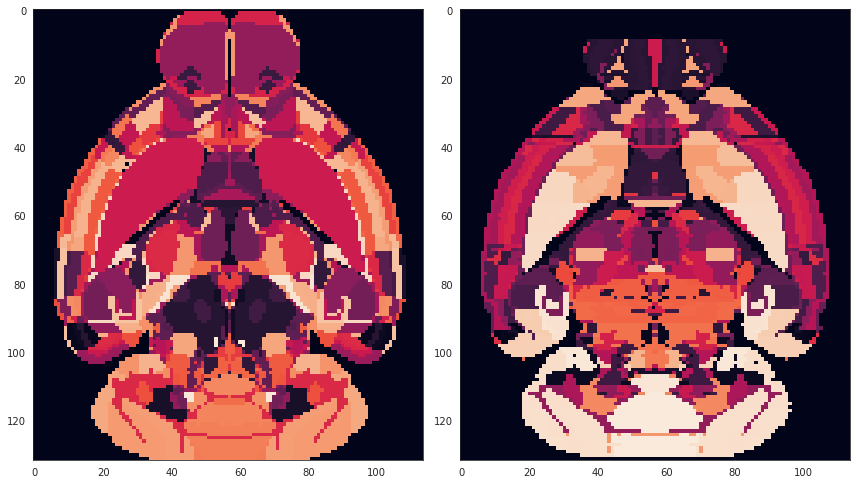

In [42]:
fig, axes = create_figure(1, 2, (12, 8))

axes[0].imshow(annot_a[:, 40, :])
axes[1].imshow(annot_b[:, 40, :])

## Fit SVINET

current expt: 'p-1'

[PROGRESS] experiment loaded: 'p26',  total # runs:  4895

[PROGRESS] some runs were excluded:     104 x k = 4,  1 x k = 3

[PROGRESS] experiment loaded: 'p25',  total # runs:  4931

[PROGRESS] some runs were excluded:     68 x k = 4,  1 x k = 3

[PROGRESS] experiment loaded: 'p24',  total # runs:  4930

[PROGRESS] some runs were excluded:     70 x k = 4

[PROGRESS] experiment loaded: 'p23',  total # runs:  4958

[PROGRESS] some runs were excluded:     42 x k = 4

[PROGRESS] experiment loaded: 'p22',  total # runs:  4971

[PROGRESS] some runs were excluded:     29 x k = 4

[PROGRESS] experiment loaded: 'p21',  total # runs:  4981

[PROGRESS] some runs were excluded:     19 x k = 4

[PROGRESS] experiment loaded: 'p20',  total # runs:  4992

[PROGRESS] some runs were excluded:     8 x k = 4

[PROGRESS] fit: initiated

[PROGRESS] kmeans fit: done

[PROGRESS] find best mappings: done

[PROGRESS] results aligned: done

  0%|          | 0/34658 [00:00<?, ?it/s]

[PROGRESS] membership df: done

[PROGRESS] 'result.npy' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-spatial-sym_n-128/results/SVINET/bo
ld_spearman_sub-SLC07_n128/p-1/k5-cosine-linksampling-(2021_07_22)

[PROGRESS] 'perf.df' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-spatial-sym_n-128/results/SVINET/bo
ld_spearman_sub-SLC07_n128/p-1/k5-cosine-linksampling-(2021_07_22)

[PROGRESS] 'pi_cut.df' saved at
/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-spatial-sym_n-128/results/SVINET/bo
ld_spearman_sub-SLC07_n128/p-1/k5-cosine-linksampling-(2021_07_22)

  0%|          | 0/100 [00:00<?, ?it/s]

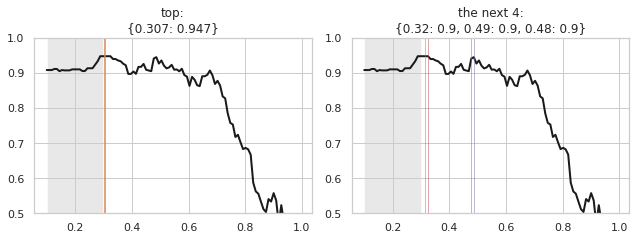

[PROGRESS] process results: done

Scene saved at /home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-spatial-sym_n-128/re
sults/SVINET/bold_spearman_sub-SLC07_n128/p-1/k5-cosine-linksampling-(2021_07_22)/render/over
lap_cortex_k5.html

Scene saved at /home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-spatial-sym_n-128/re
sults/SVINET/bold_spearman_sub-SLC07_n128/p-1/k5-cosine-linksampling-(2021_07_22)/render/disj
oint_cortex_k5.html

Scene saved at /home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-spatial-sym_n-128/re
sults/SVINET/bold_spearman_sub-SLC07_n128/p-1/k5-cosine-linksampling-(2021_07_22)/render/over
lap_brain_k5.html

Scene saved at /home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-spatial-sym_n-128/re
sults/SVINET/bold_spearman_sub-SLC07_n128/p-1/k5-cosine-linksampling-(2021_07_22)/render/disj
oint_brain_k5.html

[PROGRESS] fit: done!

00 - 00:15:04  (dd - hh:mm:ss)

In [19]:
k = 5
p = -1

start = time()
svinet = SVINET(
    mice=mice,
    num_k=k,
    perc=p,
    key=key,
    mode=mode,
    metric=metric,
    match_metric=match_metric,
    verbose=True,
).load_runs(svinet_ws).fit()
convert_time(time()-start)

In [20]:
svinet.scores()

+---------------+-------+-------+
| type          |  over | score |
+---------------+-------+-------+
| pi symmetry   |  oc1  |  0.97 |
| pi symmetry   |  oc2  |  0.97 |
| pi symmetry   |  oc3  |  0.97 |
| pi symmetry   |  oc4  |  0.94 |
| pi symmetry   |  oc5  |  0.93 |
| pi symmetry   |  avg  |  0.95 |
| ---           |  ---  |  ---  |
| entropy score | nodes |  0.92 |
| ---           |  ---  |  ---  |
| cosine        | nodes |  0.85 |
| correlation   | nodes |  0.78 |
| braycurtis    | nodes |  0.7  |
| jensenshannon | nodes |  0.71 |
+---------------+-------+-------+

In [97]:
"""
list(svinet._runs)
_ = svinet._runs.pop(20)
svinet.fit()
"""


"""
mice = Mice(Config(128))
mice.combine_dfs('rest')
svinet = SVINET(mice, 5, -1, key, verbose=True).load_results()
"""

In [99]:
svinet.path.split('/')

[
    '',
    'home',
    'hadi',
    'Documents',
    'Ca-fMRI',
    'processed',
    'norm-global_parcel-spatial-sym_n-128',
    'results',
    'SVINET',
    'bold_spearman_sub-SLC_n128',
    'p-1',
    'k5-cosine-linksampling-(2021_07_20)'
]

In [100]:
list(svinet.get_result_dict())[:5]

[
    'n138-k5-mmsb-seed1-linksampling-p35',
    'n138-k5-mmsb-seed2-linksampling-p35',
    'n138-k5-mmsb-seed3-linksampling-p35',
    'n138-k5-mmsb-seed4-linksampling-p35',
    'n138-k5-mmsb-seed5-linksampling-p35'
]

In [21]:
pi_all = collections.defaultdict(list)
for name, run in svinet.get_result_dict().items():
    p = int(name.split('-')[-1][1:])
    pi_all[p].append(np.expand_dims(run['pi'], axis=0))

pi_various = {}
for k, v in pi_all.items():
    pi_various[k] = np.concatenate(v).mean(0)

In [22]:
list(pi_various)

[26, 25, 24, 23, 22, 21, 20]

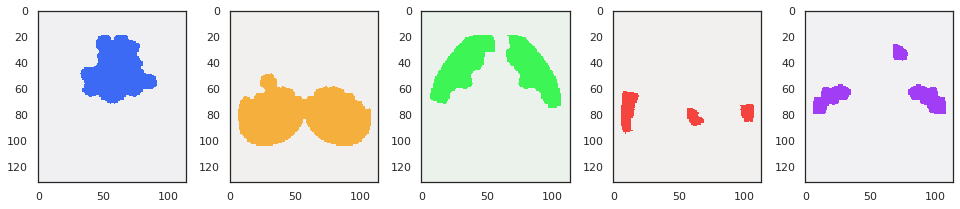

In [23]:
masks = svinet.masks_from_pi(pi_various[20], disjoint=True, cortex_only=True)

fig, axes = create_figure(1, svinet.num_k, (13.5, 3.5))
for idx in range(1, svinet.num_k + 1):
    x = project_vol_2d(masks[idx], mice.allen['dims_flat'], mode='max_proj')
    axes[idx-1].imshow(x, cmap=svinet.cmaps[idx])

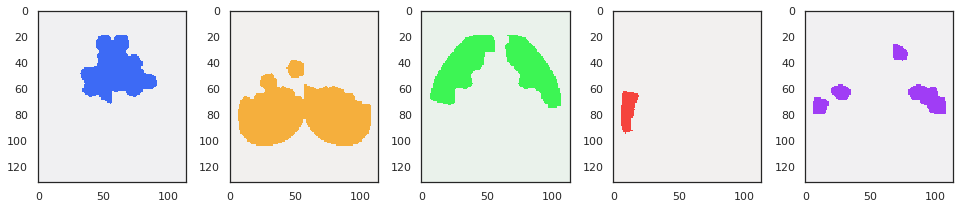

In [24]:
masks = svinet.masks_from_pi(pi_various[26], disjoint=True, cortex_only=True)

fig, axes = create_figure(1, svinet.num_k, (13.5, 3.5))
for idx in range(1, svinet.num_k + 1):
    x = project_vol_2d(masks[idx], mice.allen['dims_flat'], mode='max_proj')
    axes[idx-1].imshow(x, cmap=svinet.cmaps[idx])
    

In [153]:
np.linspace(23, 19, 5)

array([23., 22., 21., 20., 19.])

In [ ]:
np.linspace(23, 19, 5)

In [155]:
23 - 19 + 1


5

In [31]:
np.linspace(29, 20, 10)

array([29., 28., 27., 26., 25., 24., 23., 22., 21., 20.])

In [7]:
svinet.scores()

+---------------+-------+-------+
| type          |  over | score |
+---------------+-------+-------+
| pi symmetry   |  oc1  |  0.98 |
| pi symmetry   |  oc2  |  0.85 |
| pi symmetry   |  oc3  |  0.98 |
| pi symmetry   |  oc4  |  0.86 |
| pi symmetry   |  oc5  |  0.97 |
| pi symmetry   |  oc6  |  0.86 |
| pi symmetry   |  avg  |  0.92 |
| ---           |  ---  |  ---  |
| entropy score | nodes |  0.91 |
| ---           |  ---  |  ---  |
| cosine        | nodes |  0.87 |
| correlation   | nodes |  0.82 |
| braycurtis    | nodes |  0.74 |
| jensenshannon | nodes |  0.74 |
+---------------+-------+-------+

In [8]:
len(svinet.get_result_dict())

36563

+---------------+-------+-------+
| type          |  over | score |
+---------------+-------+-------+
| pi symmetry   |  oc1  |  0.97 |
| pi symmetry   |  oc2  |  0.97 |
| pi symmetry   |  oc3  |  0.97 |
| pi symmetry   |  oc4  |  0.89 |
| pi symmetry   |  oc5  |  0.98 |
| pi symmetry   |  avg  |  0.96 |
| ---           |  ---  |  ---  |
| entropy score | nodes |  0.95 |
| ---           |  ---  |  ---  |
| cosine        | nodes |  0.83 |
| correlation   | nodes |  0.74 |
| braycurtis    | nodes |  0.68 |
| jensenshannon | nodes |  0.7  |
+---------------+-------+-------+

In [5]:
len(svinet.get_result_dict())

18489

In [6]:
list(svinet.get_result_dict())[:10]

[
    'n138-k5-mmsb-seed1-linksampling-p35',
    'n138-k5-mmsb-seed2-linksampling-p35',
    'n138-k5-mmsb-seed3-linksampling-p35',
    'n138-k5-mmsb-seed4-linksampling-p35',
    'n138-k5-mmsb-seed5-linksampling-p35',
    'n138-k5-mmsb-seed6-linksampling-p35',
    'n138-k5-mmsb-seed7-linksampling-p35',
    'n138-k5-mmsb-seed8-linksampling-p35',
    'n138-k5-mmsb-seed9-linksampling-p35',
    'n138-k5-mmsb-seed10-linksampling-p35'
]

current expt: 'p-1'

[PROGRESS] loading 'k6-cosine-linksampling-(2021_07_20)' from
'/home/hadi/Documents/Ca-fMRI/processed/norm-global_parcel-spatial-sym_n-128/results/SVINET/b
old_spearman_sub-SLC_n128/p-1'

  0%|          | 0/100 [00:00<?, ?it/s]

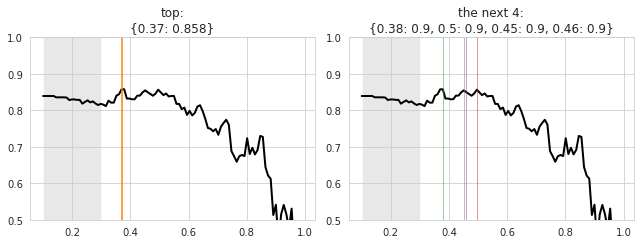

[PROGRESS] process results: done

[PROGRESS] 50 results loaded

00 - 00:00:23  (dd - hh:mm:ss)

In [3]:
start = time()
svinet = SVINET(
    mice=mice,
    num_k=6,
    perc=-1,
    key=key,
    mode=mode,
    metric=metric,
    match_metric=match_metric,
    verbose=True,
).load_results(full_process=True)
convert_time(time()-start)

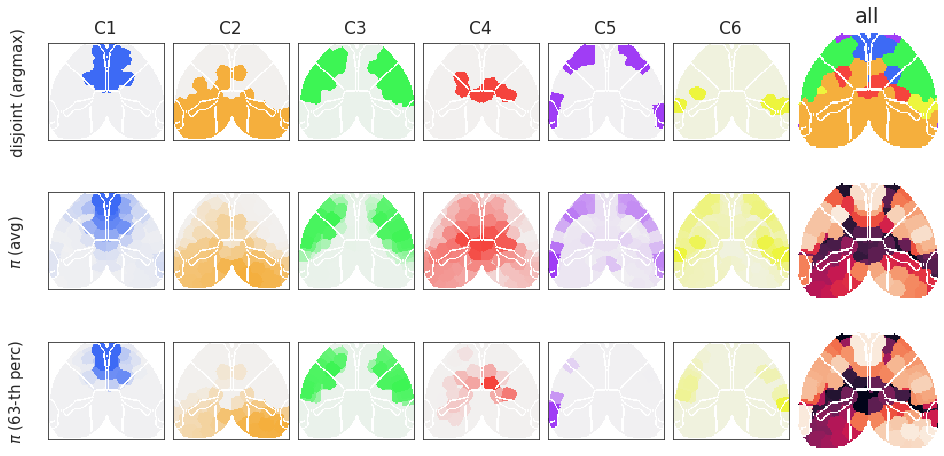

In [4]:
_ = svinet.plot_memberships_2d()

In [8]:
svinet.perf_df

,oc_idx,p,run,metric,score
0,1,35,n138-k6-mmsb-seed1-linksampling,cosine,0.065448
1,2,35,n138-k6-mmsb-seed1-linksampling,cosine,0.872947
2,3,35,n138-k6-mmsb-seed1-linksampling,cosine,0.963539
3,4,35,n138-k6-mmsb-seed1-linksampling,cosine,0.695601
4,5,35,n138-k6-mmsb-seed1-linksampling,cosine,0.786379
...,...,...,...,...,...
512675,6,17,n138-k6-mmsb-seed1000-linksampling,jensenshannon,0.466115
512676,all,17,n138-k6-mmsb-seed1000-linksampling,cosine,0.753825
512677,all,17,n138-k6-mmsb-seed1000-linksampling,correlation,0.675412
512678,all,17,n138-k6-mmsb-seed1000-linksampling,braycurtis,0.585393


In [9]:
df = svinet.perf_df
_df = df.loc[df.oc_idx == 'all']

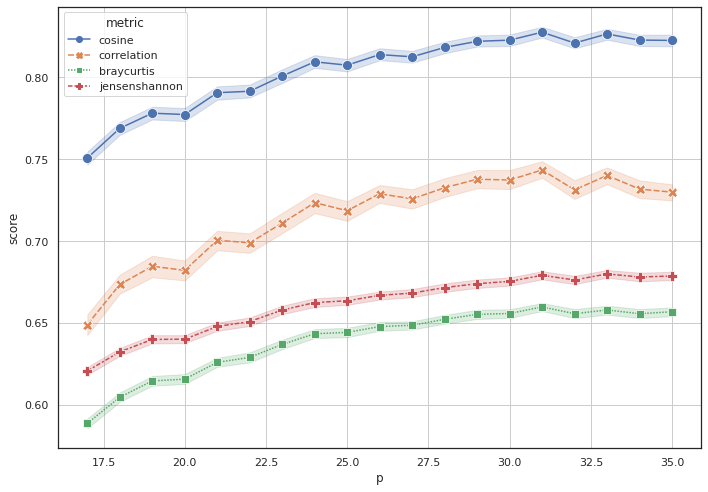

In [10]:
fig, ax = create_figure(1, 1, (10, 7))
sns.lineplot(
    data=_df,
    x='p',
    y='score',
    hue='metric',
    style='metric',
    markers=True,
    markersize=10,
    ax=ax,
)
ax.grid(axis='both')

### Load

In [191]:
h = {}
pi = {}
dict_list = []
for k in tqdm([4, 5, 6]):
    for p in [10, 15, 20, 25, 30]:
        svinet = SVINET(
            mice=mice,
            num_k=k,
            perc=p,
            key=key,
            mode=mode,
            metric=metric,
            match_metric=match_metric,
            verbose=False,
        ).load_results(full_process=False)
        
        h[f"k{k}-p{p}"] = svinet.h        
        pi[f"k{k}-p{p}"] = svinet.pi

        scores = svinet.pi_symmetry_score(decimals=10)
        data_dict = {
            'k': [k] * len(scores),
            'p': [p] * len(scores),
            'measure': ['pi_symm'] * len(scores),
            'score': scores.values(),
            'oc_idx': scores.keys(),
        }
        dict_list.append(data_dict)
        
        scores = svinet.node_similarity_score(decimals=10)
        data_dict = {
            'k': [k] * len(scores),
            'p': [p] * len(scores),
            'measure': scores.keys(),
            'score': scores.values(),
            'oc_idx': [-1] * len(scores),
        }
        dict_list.append(data_dict)
        
        data_dict = {
            'k': [k],
            'p': [p],
            'measure': ['entropy'],
            'score': [svinet.entropy_score(decimals=10)],
            'oc_idx': [-1],
        }
        dict_list.append(data_dict)

df = pd.DataFrame(merge_dicts(dict_list))

  0%|          | 0/3 [00:00<?, ?it/s]

In [192]:
svinet.scores()

+---------------+-------+-------+
| type          |  over | score |
+---------------+-------+-------+
| pi symmetry   |  oc1  |  0.97 |
| pi symmetry   |  oc2  |  0.97 |
| pi symmetry   |  oc3  |  0.97 |
| pi symmetry   |  oc4  |  0.89 |
| pi symmetry   |  oc5  |  0.95 |
| pi symmetry   |  oc6  |  0.97 |
| pi symmetry   |  avg  |  0.95 |
| ---           |  ---  |  ---  |
| entropy score | nodes |  0.96 |
| ---           |  ---  |  ---  |
| cosine        | nodes |  0.83 |
| correlation   | nodes |  0.75 |
| braycurtis    | nodes |  0.67 |
| jensenshannon | nodes |  0.69 |
+---------------+-------+-------+

In [193]:
df

,k,p,measure,score,oc_idx
0,4,10,pi_symm,0.942348,1
1,4,10,pi_symm,0.969062,2
2,4,10,pi_symm,0.967749,3
3,4,10,pi_symm,0.891734,4
4,4,10,pi_symm,0.942723,-1
...,...,...,...,...,...
160,6,30,cosine,0.830561,-1
161,6,30,correlation,0.751082,-1
162,6,30,braycurtis,0.674990,-1
163,6,30,jensenshannon,0.689412,-1


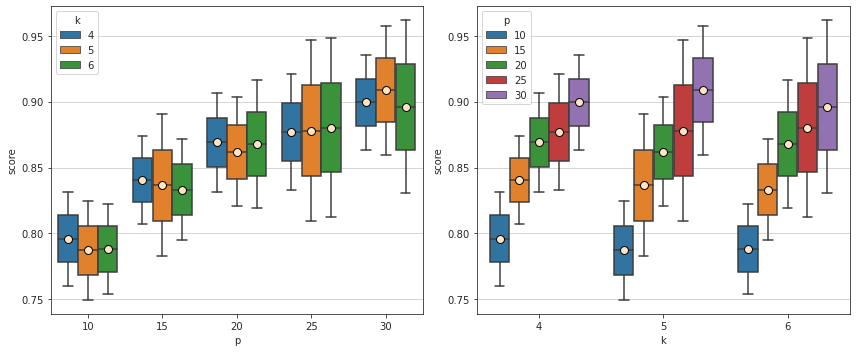

In [194]:
fig, axes = create_figure(1, 2, (12, 5), 'ticks')

_df = df.loc[
    df.measure.isin(['cosine', 'entropy', 'pi_sym']) &
    (df.oc_idx == -1)
]

meanprops = {
    "marker": "o",
    "markerfacecolor": "bisque",
    "markeredgecolor": "black",
    "markersize": "8",
}
for i in range(2):
    sns.boxplot(
        data=_df,
        hue='k' if i == 0 else 'p',
        x='p' if i == 0 else 'k',
        y='score',
        showmeans=True,
        meanprops=meanprops,
        ax=axes[i],
    )
    axes[i].grid(axis='y')

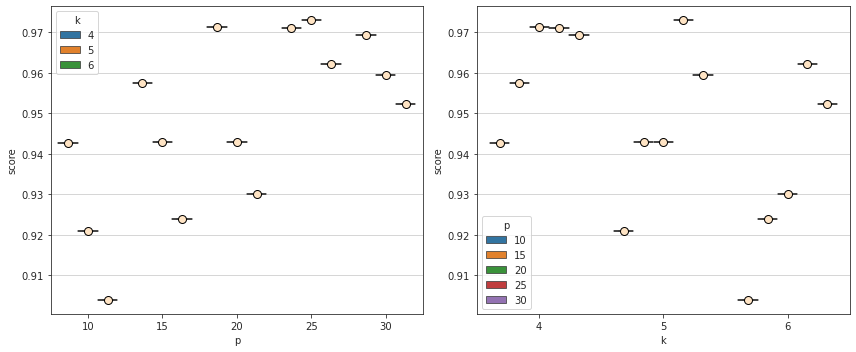

In [195]:
fig, axes = create_figure(1, 2, (12, 5), 'ticks')

_df = df.loc[
    (df.measure == 'pi_symm') &
    (df.oc_idx == -1)
]
meanprops = {
    "marker": "o",
    "markerfacecolor": "bisque",
    "markeredgecolor": "black",
    "markersize": "8",
}
for i in range(2):
    sns.boxplot(
        data=_df,
        hue='k' if i == 0 else 'p',
        x='p' if i == 0 else 'k',
        y='score',
        showmeans=True,
        meanprops=meanprops,
        ax=axes[i],
    )
    axes[i].grid(axis='y')

In [197]:
pi_algn = {}
for k in [4, 5, 6]:
    for p in [10, 15, 20, 25, 30]:
        x1 = pi[f"k{k}-p{25}"]
        x2 = pi[f"k{k}-p{p}"]
        
        d = sp_dist.cdist(x1, x2, metric='cosine')
        sim = dist2sim(d)
        mapping = find_best_match(sim)
        if any(k != v for k, v in mapping.items()):
            print(k, p, mapping)
        pi_algn[f"k{k}-p{p}"] = x2[list(mapping.values())]

4 15
{0: 3, 1: 1, 2: 2, 3: 0}

4 20
{0: 3, 1: 1, 2: 2, 3: 0}

5 10
{0: 0, 1: 1, 2: 2, 3: 4, 4: 3}

5 30
{0: 0, 1: 1, 2: 2, 3: 4, 4: 3}

6 10
{0: 0, 1: 1, 2: 2, 3: 5, 4: 4, 5: 3}

In [198]:
dict_list = [] 
for k in [4, 5, 6]:
    for p1, p2 in itertools.combinations([10, 15, 20, 25, 30], 2):
        x1 = pi[f"k{k}-p{p1}"]
        x2 = pi[f"k{k}-p{p2}"]
        d = sp_dist.cdist(x1, x2, metric='cosine')
        sim = dist2sim(d)
        mapping = find_best_match(sim)
        sim = sim[:, list(mapping.values())]
        sim = np.diag(sim)
        
        data_dict = {
            'k': [k] * len(sim),
            'p1': [p1] * len(sim),
            'p2': [p2] * len(sim),
            'sim': ['pi'] * len(sim),
            'val': sim,
        }
        dict_list.append(data_dict)
        
        x1 = h[f"k{k}-p{p1}"]
        x2 = h[f"k{k}-p{p2}"]
        d = sp_dist.cosine(x1, x2)
        sim = dist2sim(d)

        data_dict = {
            'k': [k],
            'p1': [p1],
            'p2': [p2],
            'sim': ['h'],
            'val': [sim],
        }
        dict_list.append(data_dict)
        
df_sim = pd.DataFrame(merge_dicts(dict_list))

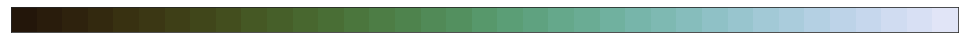

In [199]:
cmap = sns.cubehelix_palette(
    start=1,
    dark=0.10,
    light=0.90,
    rot=0.7,
    reverse=True,
    as_cmap=True,
)
display_cmap(cmap)

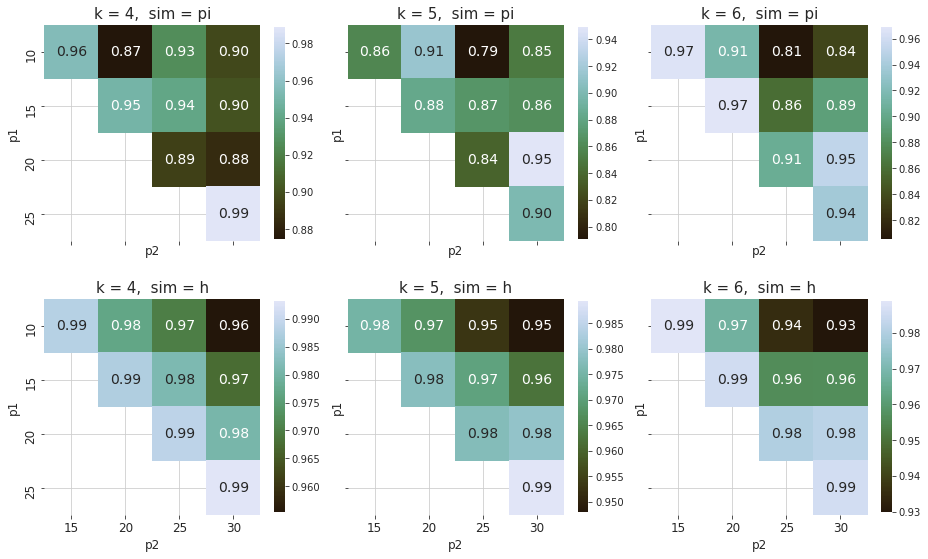

In [200]:
fig, axes = create_figure(2, 3, (13, 9), 'ticks', 'all', 'all', constrained_layout=False, tight_layout=True)

for j, k in enumerate([4, 5, 6]):
    for i in range(2):
        sim = 'pi' if i == 0 else 'h'
        _df = df_sim.loc[
            (df_sim.sim == sim) &
            (df_sim.k == k)
        ]
        _df = _df.groupby(['p1', 'p2']).mean().unstack().val

        sns.heatmap(
            data=_df,
            square=True,
            annot=True,
            fmt='.2f',
            cmap=cmap,
            annot_kws={'fontsize': 14},
            cbar_kws={'shrink': 0.6},
            ax=axes[i, j],
        )
        axes[i, j].set_title(f"k = {k},  sim = {sim}", fontsize=15)
        axes[i, j].tick_params('both', labelsize=12)
        axes[i, j].xaxis.label.set_fontsize(12)
        axes[i, j].yaxis.label.set_fontsize(12)
        axes[i, j].grid()
    
plt.show()

In [258]:
k = 6

pi_global = dict(filter(
    lambda x: f"k{k}" in x[0] and f"p{10}" not in x[0] and f"p{15}" not in x[0],
    pi_algn.items()
))
pi_global = [np.expand_dims(v, axis=0) for v in pi_global.values()]
pi_global = np.concatenate(pi_global).mean(0)
pi_global.shape

(6, 138)

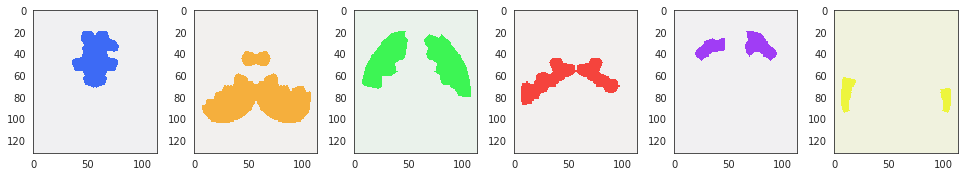

In [259]:
masks = svinet.masks_from_pi(pi_global, disjoint=True, cortex_only=True)

fig, axes = create_figure(1, k, (13.5, 3.5))
for idx in range(1, k + 1):
    x = project_vol_2d(masks[idx], mice.allen['dims_flat'], mode='max_proj')
    axes[idx-1].imshow(x, cmap=svinet.cmaps[idx])

In [255]:
svinet.pi_symmetry_score(pi_global)

{1: 0.97, 2: 0.97, 3: 0.97, 4: 0.9, 5: 0.97, 6: 0.97, -1: 0.96}

In [3]:
svinet = SVINET(
    mice=mice,
    num_k=6,
    perc=30,
    key=key,
    mode=mode,
    metric=metric,
    match_metric=match_metric,
    verbose=False,
).load_results(full_process=False)

In [4]:
svinet.scores()

+---------------+-------+-------+
| type          |  over | score |
+---------------+-------+-------+
| pi symmetry   |  oc1  |  0.97 |
| pi symmetry   |  oc2  |  0.97 |
| pi symmetry   |  oc3  |  0.97 |
| pi symmetry   |  oc4  |  0.89 |
| pi symmetry   |  oc5  |  0.95 |
| pi symmetry   |  oc6  |  0.97 |
| pi symmetry   |  avg  |  0.95 |
| ---           |  ---  |  ---  |
| entropy score | nodes |  0.96 |
| ---           |  ---  |  ---  |
| cosine        | nodes |  0.83 |
| correlation   | nodes |  0.75 |
| braycurtis    | nodes |  0.67 |
| jensenshannon | nodes |  0.69 |
+---------------+-------+-------+

In [33]:
k = 6
p = 30

start = time()
svinet = SVINET(
    mice=mice,
    num_k=k,
    perc=p,
    key=key,
    mode=mode,
    metric=metric,
    match_metric=match_metric,
    verbose=False,
).load_results(full_process=False)
convert_time(time()-start)

00 - 00:00:03  (dd - hh:mm:ss)

In [34]:
svinet.perc

30

In [35]:
svinet.path.split('/')

[
    '',
    'home',
    'hadi',
    'Documents',
    'Ca-fMRI',
    'processed',
    'norm-global_parcel-spatial-sym_n-128',
    'results',
    'SVINET',
    'bold_spearman_sub-SLC_n128',
    'p30',
    'k6-cosine-linksampling-(2021_07_18)'
]

## Group centralities

In [8]:
community = {
    idx: [svinet.l2n[region] for region in x]
    for idx, x in svinet.disjoint_community().items()
}

dict_list = []
for lbl, f in svinet._group_centrality_fn.items():
    for idx, comm_list in community.items():
        data_dict = {
            'measure': [lbl],
            'oc_idx': [idx],
            'centrality': [f(svinet.graphs[svinet.perc], comm_list)],
        }
        dict_list.append(data_dict)
grp_cent_df = pd.DataFrame(merge_dicts(dict_list))

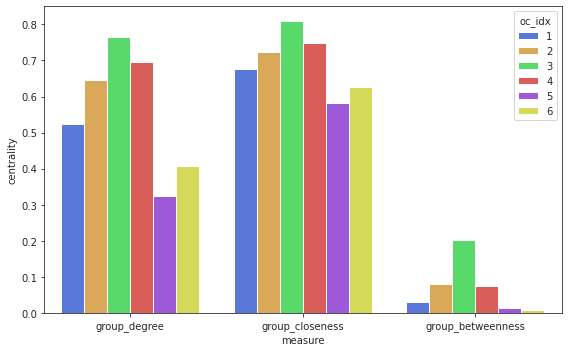

In [9]:
fig, ax = create_figure(1, 1, (8, 5), 'ticks')
sns.barplot(
    data=grp_cent_df,
    x='measure',
    y='centrality',
    hue='oc_idx',
    palette=svinet.colors,
    saturation=0.7,
    ax=ax,
)
plt.show()

In [10]:
_df = grp_cent_df.groupby(['oc_idx', 'measure']).mean().unstack()
_df = _df.centrality
_df

measure,group_betweenness,group_closeness,group_degree
oc_idx,,,
1,0.028840,0.677778,0.524590
2,0.080407,0.722628,0.646465
3,0.201496,0.809524,0.764706
4,0.074770,0.748538,0.695312
5,0.014117,0.583333,0.323308
6,0.007198,0.627551,0.406504


In [48]:
a = np.quantile(svinet.h, 0.1)
b = np.quantile(svinet.h, 0.9)
a, b

(0.33322464873319796, 0.8307728354552402)

In [327]:
low_ent = np.where(svinet.h < a)[0]
high_ent = np.where(svinet.h > b)[0]
svinet.h[low_ent].mean(), svinet.h[high_ent].mean()

(0.2558562445620093, 0.8872217300659501)

In [328]:
dict_list = []
for lbl, f in net._group_centrality_fn.items():
    for tag, group in {'low': low_ent, 'high': high_ent, }.items():
        data_dict = {
            'measure': [lbl],
            'tag': [tag],
            'centrality': [f(net.graphs[svinet.expt_name], group)],
        }
        dict_list.append(data_dict)
grp_cent_df = pd.DataFrame(merge_dicts(dict_list))

...merging dicts: 0it [00:00, ?it/s]

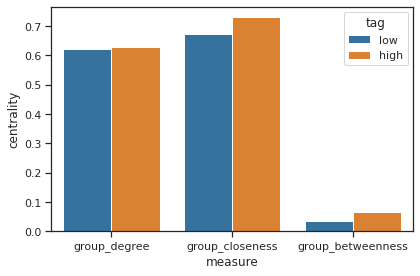

In [329]:
fig, ax = create_figure(1, 1, (6, 4), 'ticks')
sns.barplot(
    data=grp_cent_df,
    x='measure',
    y='centrality',
    hue='tag',
    palette='tab10',
    saturation=0.7,
    ax=ax,
)
plt.show()

In [330]:
high_ent = [
    mice.parcel.results['eroded_masks'][int(net.n2l[n].split('-')[-1])]
    for n in high_ent if str(315) in net.n2l[n]
]
low_ent = [
    mice.parcel.results['eroded_masks'][int(net.n2l[n].split('-')[-1])]
    for n in low_ent if str(315) in net.n2l[n]
]
mask_high_ent = functools.reduce(np.logical_or, high_ent)
mask_low_ent = functools.reduce(np.logical_or, low_ent)

In [331]:
_ = parcel2html(
    masks={0: mask_high_ent},
    save_dir=extras_dir,
    save_name='high_entropy',
    cmap=sns.light_palette('C3', as_cmap=True, reverse=True),
    alpha=0.8,
    alpha_base=0.2,
    alpha_root=0.1,
)

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/high_entropy_k1.html

In [332]:
_ = parcel2html(
    masks={0: mask_low_ent},
    save_dir=extras_dir,
    save_name='low_entropy',
    cmap=sns.light_palette('C0', as_cmap=True, reverse=True),
    alpha=0.8,
    alpha_base=0.2,
    alpha_root=0.1,
)

Scene saved at /home/hadi/Dropbox/git/jb-Ca-fMRI/_extras/low_entropy_k1.html

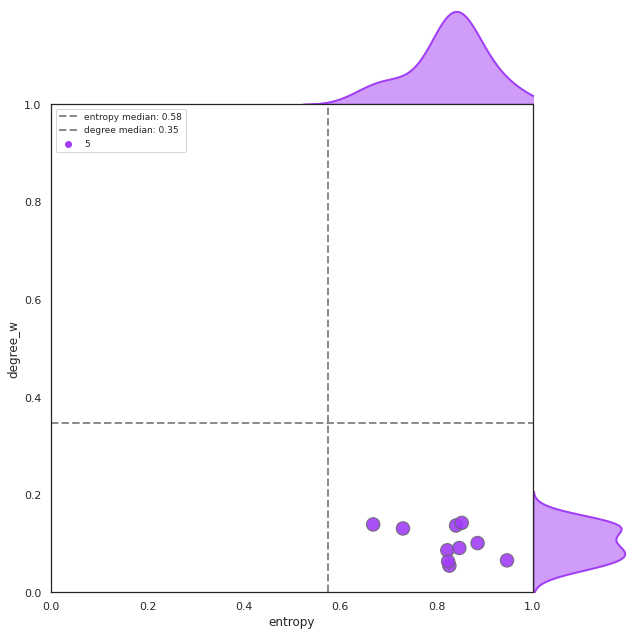

In [426]:
sns.set_theme(style='white', palette='deep')
save_dir = svinet.get_save_path('region_plots')

measure = 'degree_w'

_df = cent_df.loc[cent_df.measure.isin([measure, 'entropy'])]
_df = _df.groupby(['node', 'measure']).mean().unstack()
_df = _df.centrality
_df = pd.concat([_df, pd.DataFrame({'oc_idx': partition})], axis=1)

selected_nodes = dict(filter(lambda x: str(315) not in x[0], net.l2n.items()))
_df = _df.iloc[list(selected_nodes.values())]

jg = sns.JointGrid(
    data=_df,
    x='entropy',
    y=measure,
    hue='oc_idx',
    size=9,
    palette=svinet.colors,
    xlim=(0, 1),
    ylim=(0, 1),
    space=0.0,
)
jg.plot_joint(
    sns.scatterplot,
    hue='oc_idx',
    s=180,
    alpha=0.9,
    edgecolor='dimgrey',
)
jg.plot_marginals(
    sns.kdeplot,
    fill=True,
    alpha=0.5,
    lw=2,
)

_median = np.median(svinet.h)
jg.ax_joint.axvline(
    x=_median,
    ls='--',
    lw=2,
    alpha=1.0,
    c=sns.color_palette('deep')[7],
    label=f"entropy median: {_median:.2f}",
    zorder=0,
)
_median = cent_df.loc[cent_df.measure == 'degree_w', 'centrality'].median()
jg.ax_joint.axhline(
    y=_median,
    ls='--',
    lw=2,
    alpha=1.0,
    c=sns.color_palette('deep')[7],
    label=f"degree median: {_median:.2f}",
    zorder=0,
)
jg.ax_joint.legend(loc='upper left', prop={'size': 9})

file = pjoin(save_dir, f"{measure}-{'subcortical'}.pdf")
jg.savefig(file)
plt.show()

In [427]:
measure = 'degree_w'

_df = cent_df.loc[cent_df.measure.isin([measure, 'entropy'])]
_df = _df.groupby(['node', 'measure']).mean().unstack()
_df = _df.centrality
_df = pd.concat([_df, pd.DataFrame({'oc_idx': partition})], axis=1)

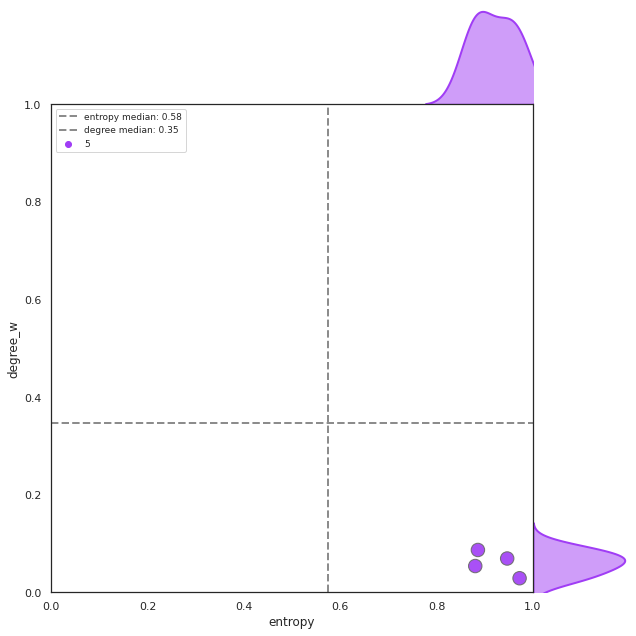

In [437]:
sns.set_theme(style='white', palette='deep')
save_dir = svinet.get_save_path('region_plots')

for acro, mask in mice.parcel.results['major_masks'].items():
    if acro not in ['PERI', 'ECT']:
        continue
    selected_nodes = list(itertools.compress(
        data=mice.parcel.results['eroded_masks'],
        selectors=[
            overlap_score(mask, m) > 0.3
            if acro in ['PERI', 'ECT'] else 0.8
            for m in mice.parcel.results['eroded_masks'].values()
        ]
    ))
    selected_nodes = [
        f"{0 if x <= mice.parcel.results['n_cortical_regions'] // 2 else 1}-315-{x}"
        for x in selected_nodes
    ]
    selected_nodes = [net.l2n[x] for x in selected_nodes]
    if not len(selected_nodes):
        continue

    jg = sns.JointGrid(
        data=_df.iloc[selected_nodes],
        x='entropy',
        y=measure,
        hue='oc_idx',
        size=9,
        palette=svinet.colors,
        xlim=(0, 1),
        ylim=(0, 1),
        space=0.0,
    )
    jg.plot_joint(
        sns.scatterplot,
        hue='oc_idx',
        s=180,
        alpha=0.9,
        edgecolor='dimgrey',
    )
    jg.plot_marginals(
        sns.kdeplot,
        fill=True,
        alpha=0.5,
        lw=2,
    )

    _median = np.median(svinet.h)
    jg.ax_joint.axvline(
        x=_median,
        ls='--',
        lw=2,
        alpha=1.0,
        c=sns.color_palette('deep')[7],
        label=f"entropy median: {_median:.2f}",
        zorder=0,
    )
    _median = cent_df.loc[cent_df.measure == 'degree_w', 'centrality'].median()
    jg.ax_joint.axhline(
        y=_median,
        ls='--',
        lw=2,
        alpha=1.0,
        c=sns.color_palette('deep')[7],
        label=f"degree median: {_median:.2f}",
        zorder=0,
    )
    jg.ax_joint.legend(loc='upper left', prop={'size': 9})

    file = pjoin(save_dir, f"{measure}-{acro}.pdf")
    jg.savefig(file)
    plt.show()

In [191]:
import networkx.algorithms.community as nx_comm

In [ ]:
nx.group_degree_centrality()

In [ ]:
a = 'degree'
b = 'eigenvector'

_df = cent_df.loc[cent_df.measure.isin([a, b])]
_df = _df.groupby(['node', 'measure']).mean().unstack()
_df = _df.centrality

x = _df.loc[:, a].values.reshape(-1, 1)
y = _df.loc[:, b].values.reshape(-1, 1)
lm = LinearRegression().fit(x, y)

fig, ax = create_figure(1, 1)

sns.regplot(
    data=_df,
    x=a,
    y=b,
    ax=ax,
)
ax.set_aspect(1 / ax.get_data_ratio())
ax.set_title(f"r = {lm.coef_.item():.2f}")
ax.set_xlabel(a)
ax.set_ylabel(b)
plt.show()

### Compare centroids and memship_vol (old stuff)

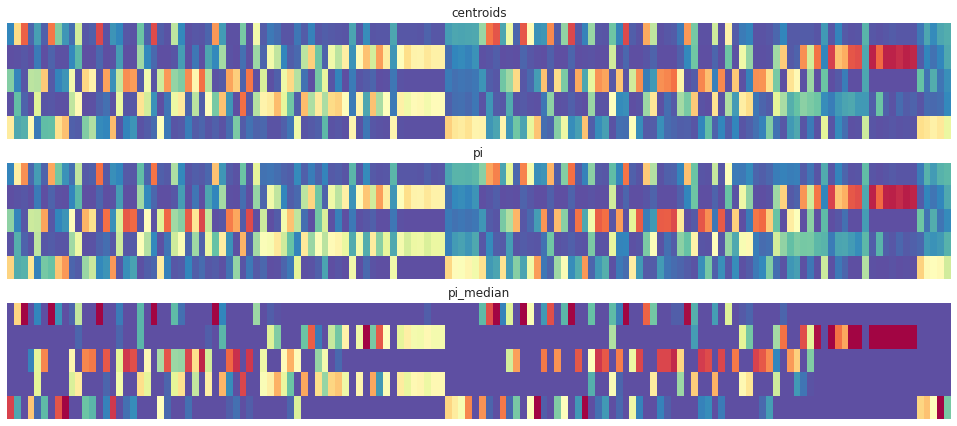

In [16]:
fig, axes = create_figure(3, 1, (13.5, 6), 'white')
data = {
    'centroids': svinet.centroids,
    'pi': svinet.pi,
    'pi_median':np.median(svinet.pi_all, axis=0),
}
for ax, (lbl, x) in zip(axes, data.items()):
    im = ax.imshow(x, cmap='Spectral_r', aspect=3.4, vmin=0, vmax=1)
    ax.set_title(lbl)
remove_ticks(axes)